# Main Script For Project Miniblock

## First: Set up the head directory

In [1]:
from pathlib import Path
import sys
from os.path import join
current_path = Path.cwd()

# look through all parents
for parent in current_path.parents:
    if parent.name == "project_miniblock":
        project_dir = parent
        break
else:
    raise FileNotFoundError("Could not find a parent folder named 'project_miniblock'.")

glmdir = project_dir.parent.parent # in my case this is true might not be true for you 
sys.path.append(join(glmdir, 'GLMsingle/python'))
sys.path.append(join(glmdir, 'fracridge/fracridge'))

from preprocessing import get_design_matrices, get_motion_parameters, accuracies_functional, accuracies_localizer
subjects = [f"{i:02d}" for i in range(1,23)]

## Create design matrices for GLMSingle

In [2]:
get_design_matrices(project_dir, subjects)

Saving files to the following directory: /Users/danieljanini/Documents/project_miniblock/Behavior/designmats
Saving files to the following directory: /Users/danieljanini/Documents/project_miniblock/Behavior/designmats/localizer
Run 3 not found for subject 01. Skipping.
Run 3 not found for subject 02. Skipping.
Run 3 not found for subject 05. Skipping.
Run 3 not found for subject 11. Skipping.
Run 3 not found for subject 12. Skipping.


## Create Plots for motion parameters and check excessive motion

Excessive movement detected in subject 09, run 9. Check the motion plots.


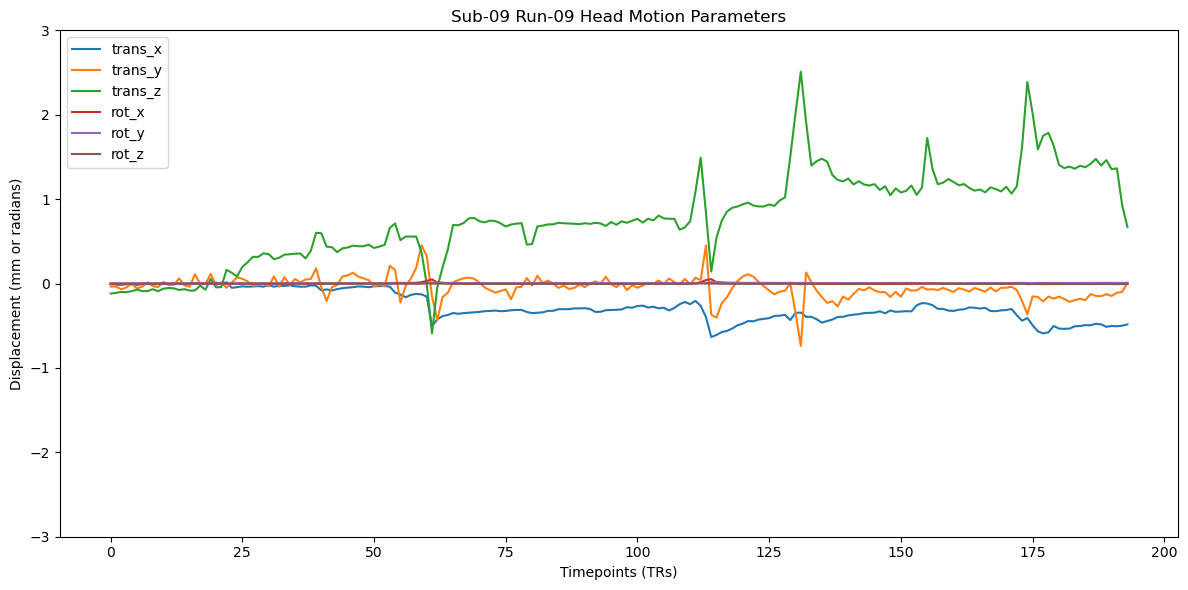

Excessive movement detected in subject 09, run 10. Check the motion plots.


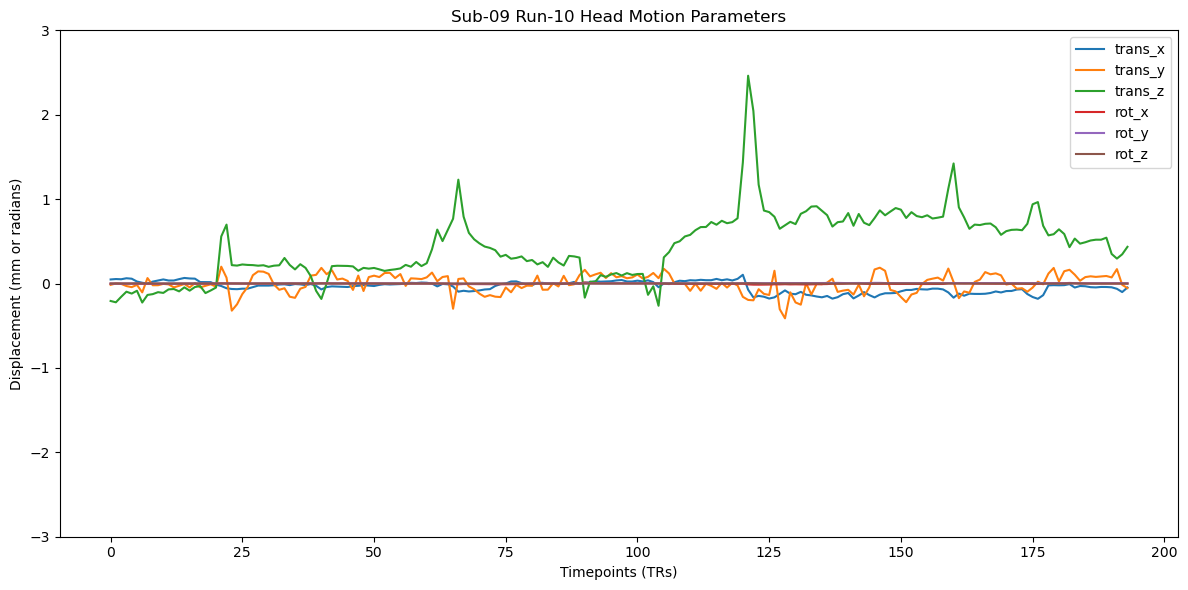

In [3]:
subjects = ["09"]
get_motion_parameters(project_dir, subjects)

## Get accuracies for functional runs

In [4]:
accuracy_df = accuracies_functional(project_dir, subjects)
localizer_acc_df = accuracies_localizer(project_dir, subjects)

## Run GLM Single

### Functional data

In [2]:
from preprocessing import glm_single_func
#subjects = [f"{i:02d}" for i in range(1, 23) if i not in [9, 16]]
subjects  = ["09"]
outputs = [0,1,0,1]

glm_single_func(project_dir, subjects, outputs)

These are er - runs and smoothing is 0
Size of Design Matrix before upsampling: (388, 40)
774
Size of Design Matrix after upsampling: (774, 40)
Size of Design Matrix before upsampling: (388, 40)
774
Size of Design Matrix after upsampling: (774, 40)
Size of Design Matrix before upsampling: (388, 40)
774
Size of Design Matrix after upsampling: (774, 40)
There are 3 runs in total

N = 774 TRs per run

The dimensions of the data for each run are: (77, 95, 82, 774)

The stimulus duration is 1 seconds

XYZ dimensionality is: (77, 95, 82) (one slice only in this example)

Numeric precision of data is: <class 'numpy.float64'>

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'firdelay': 30,
 'firpct': 99,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,


chunks:  45%|████▌     | 5/11 [07:53<09:28, 94.73s/it]


KeyboardInterrupt: 

### Localizer data

In [ ]:
from preprocessing import glm_single_loc
subjects = [f"{i:02d}" for i in range(1, 23) if i not in [9, 16]]
outputs = [0,1,0,1]

glm_single_loc(project_dir, subjects, outputs)

## Reliability

### Get Whole-Brain Maps

In [ ]:
from reliability import get_whole_brain_rel_maps

subjects = [f"{i:02d}" for i in range(1, 23) if i not in [9, 16]]
get_whole_brain_rel_maps(project_dir, subjects)